In [60]:
%matplotlib inline 
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Model
from tensorflow.keras.layers import Dense, Conv3D, Conv1D, Conv3DTranspose, Dropout, MaxPool3D, Flatten, Reshape, Input, Permute, GlobalAvgPool3D
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.optimizers import Adam, SGD
import numpy as np
from random import sample, seed
from tqdm import tqdm
import matplotlib.pyplot as plt

class AAE():
    #Adversarial Autoencoder
    def __init__(self, img_shape=(48, 96, 96, 1), encoded_dim=16, optimizer_generator = SGD(0.001, momentum=.9), 
                optimizer_discriminator = SGD(0.0001, momentum=.9), optimizer_autoencoder = Adam(0.0001)):
        self.encoded_dim = encoded_dim
        self.optimizer_generator = optimizer_generator
        self.optimizer_discriminator = optimizer_discriminator
        self.optimizer_autoencoder = optimizer_autoencoder
        self.img_shape = img_shape
        self.initializer = RandomNormal(mean=0., stddev=1.)
        self.encoder, self.decoder, self.autoencoder, self.discriminator, self.generator = self._modelCompile(
                self.img_shape, self.encoded_dim, \
                self.optimizer_autoencoder,\
                self.optimizer_discriminator,\
                self.optimizer_generator
                )

    def _buildEncoder(self, img_shape, encoded_dim):

        encoder = Sequential()
        encoder.add(Conv3D(input_shape = img_shape, filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        encoder.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(Dropout(0.2))
        encoder.add(Conv3D(filters = 32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        
        encoder.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(Dropout(0.2))
        #encoder.add(Conv3D(filters = 64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))

        #encoder.add(Conv3D(filters = 128, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        #encoder.add(MaxPool3D(pool_size=(2,)*3, padding="SAME"))
        #encoder.add(GlobalAvgPool3D())
        encoder.add(Conv3D(filters = 1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        encoder.add(Flatten())
        encoder.add(Dense(encoded_dim))
        
        return encoder

    def _buildDecoder(self, encoded_dim):

        decoder = Sequential()
        decoder.add(Dense(12*24*24, activation='relu', input_dim=encoded_dim))
        #decoder.add(Dense(3*6*6*128, activation='relu'))
        decoder.add(Reshape([12*24*24,1]))
        decoder.add(Conv1D(filters = 64, kernel_size=1, padding='SAME', activation='relu'))
        #decoder.add(Permute((2,1)))
        decoder.add(Reshape([12,24,24,64]))
        #decoder.add(Conv3DTranspose(filters=64, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        #decoder.add(Conv3DTranspose(filters=64, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=32, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=32, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=16, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=16, kernel_size=3, strides=(2,)*3, padding="SAME", activation='relu'))
        decoder.add(Conv3DTranspose(filters=1, kernel_size=3, strides=(1,)*3, padding="SAME", activation='relu'))
        
        return decoder

    def _buildDiscriminator(self, encoded_dim):

        discriminator = Sequential()
        discriminator.add(Dense(1024, input_dim=encoded_dim, activation="relu"))
        discriminator.add(Dense(1024, activation="relu"))
        discriminator.add(Dense(256, activation="relu"))
        discriminator.add(Dense(1, activation="sigmoid"))

        return discriminator

    def _modelCompile(self, img_shape, encoded_dim, optimizer_autoencoder, optimizer_discriminator, optimizer_generator):

        encoder=self._buildEncoder(img_shape, encoded_dim)
        decoder=self._buildDecoder(encoded_dim)
        
        autoencoder_input = Input(shape = img_shape)
        autoencoder=Model(autoencoder_input, decoder(encoder(autoencoder_input)))
        autoencoder.compile(optimizer=optimizer_autoencoder, loss="mae")

        discriminator=self._buildDiscriminator(encoded_dim)
        discriminator.trainable = False
        generator = Model(autoencoder_input, discriminator(encoder(autoencoder_input)))
        generator.compile(optimizer=optimizer_generator, loss="binary_crossentropy")
        discriminator.trainable = True
        discriminator.compile(optimizer=optimizer_discriminator, loss="binary_crossentropy")
    

        return encoder, decoder, autoencoder, discriminator, generator

    def train(self, train_set, batch_size, n_epochs, n_sample):

        autoencoder_losses = []
        discriminator_losses = []
        generator_losses = []

        for epoch in np.arange(1, n_epochs):
            x_idx_list = sample(range(n_sample), batch_size)
            x = train_set[x_idx_list]

            autoencoder_history = self.autoencoder.train_on_batch(x,x)
            fake_latent = self.encoder.predict(x)
            discriminator_input = np.concatenate((fake_latent, np.random.randn(batch_size, self.encoded_dim)))
            discriminator_labels = np.concatenate((np.zeros((batch_size, 1)), np.ones((batch_size, 1))))
            
            discriminator_history = self.discriminator.train_on_batch(discriminator_input, discriminator_labels)
            generator_history = self.generator.train_on_batch(x, np.ones((batch_size, 1)))
            
            autoencoder_losses.append(autoencoder_history)
            discriminator_losses.append(discriminator_history)
            generator_losses.append(generator_history)

            if epoch % 50 == 0:
                self.autoencoder.save("./train_log/autoencoder_epoch_{}.h5".format(epoch))
                self.discriminator.save("./train_log/autoencoder_epoch_{}.h5".format(epoch))
            print("Epoch--{}".format(epoch))
            print("AE_loss: {:.4f}  D_loss:{:.3f}   G_loss:{:.3f}".format(autoencoder_history, discriminator_history, generator_history))

        self.history = {'AE_loss':autoencoder_losses, 'D_loss':discriminator_losses, 'G_loss':generator_losses}
        
        return self.history

    def load_model(self):

        return

    def encodeImage(self):

        return 

    def plot_losses(self):

        return

In [61]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
# Invalid device or cannot modify virtual devices once initialized.
    pass

model = AAE()

import os
import SimpleITK as sitk 

datapath = r'../Data'
file_reference = r'../training/File_reference.csv'

img_ls = os.listdir(datapath)
train_set = np.zeros(shape=[len(img_ls), 48, 96, 96, 1])

idx = 0
for file in tqdm(img_ls):
    img = sitk.ReadImage(os.path.join(datapath, file))
    img = sitk.GetArrayFromImage(img)
    img = img[:,2:98,2:98,np.newaxis].astype(np.float32) / 255.
    train_set[idx] = img
    idx += 1

model = AAE(encoded_dim=512)

batch_size=12
n_epochs=1000
seed=42
np.random.seed(42)

history = model.train(train_set, batch_size, n_epochs, len(img_ls))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1198/1198 [00:13<00:00, 91.87it/s]


Epoch--1
AE_loss: 0.0590  D_loss:0.642   G_loss:0.692
Epoch--2
AE_loss: 0.0656  D_loss:0.669   G_loss:0.692
Epoch--3
AE_loss: 0.0587  D_loss:0.658   G_loss:0.692
Epoch--4
AE_loss: 0.0690  D_loss:0.670   G_loss:0.693
Epoch--5
AE_loss: 0.0710  D_loss:0.669   G_loss:0.692
Epoch--6
AE_loss: 0.0640  D_loss:0.647   G_loss:0.692
Epoch--7
AE_loss: 0.0685  D_loss:0.693   G_loss:0.692
Epoch--8
AE_loss: 0.0604  D_loss:0.609   G_loss:0.692
Epoch--9
AE_loss: 0.0773  D_loss:0.669   G_loss:0.691
Epoch--10
AE_loss: 0.0644  D_loss:0.652   G_loss:0.691
Epoch--11
AE_loss: 0.0709  D_loss:0.697   G_loss:0.691
Epoch--12
AE_loss: 0.0738  D_loss:0.650   G_loss:0.690
Epoch--13
AE_loss: 0.0673  D_loss:0.687   G_loss:0.689
Epoch--14
AE_loss: 0.0610  D_loss:0.646   G_loss:0.689
Epoch--15
AE_loss: 0.0757  D_loss:0.627   G_loss:0.686
Epoch--16
AE_loss: 0.0671  D_loss:0.655   G_loss:0.686
Epoch--17
AE_loss: 0.0589  D_loss:0.650   G_loss:0.683
Epoch--18
AE_loss: 0.0681  D_loss:0.602   G_loss:0.681
Epoch--19
AE_loss: 

Epoch--147
AE_loss: 0.0616  D_loss:1.301   G_loss:0.694
Epoch--148
AE_loss: 0.0682  D_loss:1.363   G_loss:0.694
Epoch--149
AE_loss: 0.0596  D_loss:1.287   G_loss:0.693
Epoch--150
AE_loss: 0.0608  D_loss:1.324   G_loss:0.693
Epoch--151
AE_loss: 0.0642  D_loss:1.344   G_loss:0.693
Epoch--152
AE_loss: 0.0720  D_loss:1.256   G_loss:0.693
Epoch--153
AE_loss: 0.0640  D_loss:1.226   G_loss:0.693
Epoch--154
AE_loss: 0.0652  D_loss:1.208   G_loss:0.692
Epoch--155
AE_loss: 0.0694  D_loss:1.150   G_loss:0.692
Epoch--156
AE_loss: 0.0694  D_loss:1.240   G_loss:0.692
Epoch--157
AE_loss: 0.0663  D_loss:1.151   G_loss:0.692
Epoch--158
AE_loss: 0.0619  D_loss:1.213   G_loss:0.691
Epoch--159
AE_loss: 0.0574  D_loss:1.152   G_loss:0.691
Epoch--160
AE_loss: 0.0599  D_loss:1.105   G_loss:0.691
Epoch--161
AE_loss: 0.0683  D_loss:1.105   G_loss:0.691
Epoch--162
AE_loss: 0.0668  D_loss:1.141   G_loss:0.691
Epoch--163
AE_loss: 0.0669  D_loss:1.077   G_loss:0.690
Epoch--164
AE_loss: 0.0682  D_loss:1.030   G_los

Epoch--294
AE_loss: 0.0658  D_loss:0.505   G_loss:0.653
Epoch--295
AE_loss: 0.0546  D_loss:0.492   G_loss:0.653
Epoch--296
AE_loss: 0.0679  D_loss:0.498   G_loss:0.653
Epoch--297
AE_loss: 0.0750  D_loss:0.460   G_loss:0.652
Epoch--298
AE_loss: 0.0715  D_loss:0.476   G_loss:0.652
Epoch--299
AE_loss: 0.0620  D_loss:0.479   G_loss:0.652
Epoch--300
AE_loss: 0.0681  D_loss:0.473   G_loss:0.652
Epoch--301
AE_loss: 0.0616  D_loss:0.464   G_loss:0.651
Epoch--302
AE_loss: 0.0651  D_loss:0.478   G_loss:0.651
Epoch--303
AE_loss: 0.0572  D_loss:0.482   G_loss:0.651
Epoch--304
AE_loss: 0.0738  D_loss:0.465   G_loss:0.650
Epoch--305
AE_loss: 0.0619  D_loss:0.484   G_loss:0.650
Epoch--306
AE_loss: 0.0687  D_loss:0.464   G_loss:0.650
Epoch--307
AE_loss: 0.0700  D_loss:0.466   G_loss:0.649
Epoch--308
AE_loss: 0.0733  D_loss:0.475   G_loss:0.649
Epoch--309
AE_loss: 0.0609  D_loss:0.474   G_loss:0.649
Epoch--310
AE_loss: 0.0722  D_loss:0.473   G_loss:0.648
Epoch--311
AE_loss: 0.0683  D_loss:0.479   G_los

Epoch--441
AE_loss: 0.0626  D_loss:0.457   G_loss:0.606
Epoch--442
AE_loss: 0.0680  D_loss:0.447   G_loss:0.605
Epoch--443
AE_loss: 0.0655  D_loss:0.442   G_loss:0.605
Epoch--444
AE_loss: 0.0613  D_loss:0.444   G_loss:0.605
Epoch--445
AE_loss: 0.0604  D_loss:0.442   G_loss:0.604
Epoch--446
AE_loss: 0.0641  D_loss:0.437   G_loss:0.604
Epoch--447
AE_loss: 0.0739  D_loss:0.443   G_loss:0.604
Epoch--448
AE_loss: 0.0684  D_loss:0.446   G_loss:0.604
Epoch--449
AE_loss: 0.0713  D_loss:0.437   G_loss:0.603
Epoch--450
AE_loss: 0.0529  D_loss:0.446   G_loss:0.603
Epoch--451
AE_loss: 0.0612  D_loss:0.441   G_loss:0.603
Epoch--452
AE_loss: 0.0661  D_loss:0.434   G_loss:0.602
Epoch--453
AE_loss: 0.0635  D_loss:0.450   G_loss:0.602
Epoch--454
AE_loss: 0.0700  D_loss:0.449   G_loss:0.602
Epoch--455
AE_loss: 0.0661  D_loss:0.444   G_loss:0.602
Epoch--456
AE_loss: 0.0651  D_loss:0.445   G_loss:0.601
Epoch--457
AE_loss: 0.0711  D_loss:0.439   G_loss:0.601
Epoch--458
AE_loss: 0.0657  D_loss:0.443   G_los

Epoch--588
AE_loss: 0.0743  D_loss:0.451   G_loss:0.574
Epoch--589
AE_loss: 0.0673  D_loss:0.459   G_loss:0.573
Epoch--590
AE_loss: 0.0705  D_loss:0.448   G_loss:0.573
Epoch--591
AE_loss: 0.0688  D_loss:0.452   G_loss:0.573
Epoch--592
AE_loss: 0.0663  D_loss:0.449   G_loss:0.573
Epoch--593
AE_loss: 0.0665  D_loss:0.448   G_loss:0.573
Epoch--594
AE_loss: 0.0688  D_loss:0.451   G_loss:0.573
Epoch--595
AE_loss: 0.0719  D_loss:0.450   G_loss:0.573
Epoch--596
AE_loss: 0.0636  D_loss:0.452   G_loss:0.573
Epoch--597
AE_loss: 0.0687  D_loss:0.451   G_loss:0.572
Epoch--598
AE_loss: 0.0651  D_loss:0.454   G_loss:0.572
Epoch--599
AE_loss: 0.0566  D_loss:0.456   G_loss:0.572
Epoch--600
AE_loss: 0.0602  D_loss:0.450   G_loss:0.572
Epoch--601
AE_loss: 0.0708  D_loss:0.451   G_loss:0.572
Epoch--602
AE_loss: 0.0591  D_loss:0.452   G_loss:0.572
Epoch--603
AE_loss: 0.0623  D_loss:0.448   G_loss:0.572
Epoch--604
AE_loss: 0.0640  D_loss:0.458   G_loss:0.572
Epoch--605
AE_loss: 0.0658  D_loss:0.454   G_los

Epoch--735
AE_loss: 0.0722  D_loss:0.450   G_loss:0.569
Epoch--736
AE_loss: 0.0625  D_loss:0.451   G_loss:0.569
Epoch--737
AE_loss: 0.0720  D_loss:0.444   G_loss:0.569
Epoch--738
AE_loss: 0.0726  D_loss:0.449   G_loss:0.569
Epoch--739
AE_loss: 0.0687  D_loss:0.450   G_loss:0.570
Epoch--740
AE_loss: 0.0602  D_loss:0.454   G_loss:0.570
Epoch--741
AE_loss: 0.0629  D_loss:0.451   G_loss:0.570
Epoch--742
AE_loss: 0.0634  D_loss:0.447   G_loss:0.570
Epoch--743
AE_loss: 0.0593  D_loss:0.450   G_loss:0.570
Epoch--744
AE_loss: 0.0686  D_loss:0.455   G_loss:0.570
Epoch--745
AE_loss: 0.0530  D_loss:0.450   G_loss:0.570
Epoch--746
AE_loss: 0.0692  D_loss:0.454   G_loss:0.570
Epoch--747
AE_loss: 0.0713  D_loss:0.451   G_loss:0.570
Epoch--748
AE_loss: 0.0666  D_loss:0.452   G_loss:0.570
Epoch--749
AE_loss: 0.0675  D_loss:0.451   G_loss:0.570
Epoch--750
AE_loss: 0.0705  D_loss:0.450   G_loss:0.570
Epoch--751
AE_loss: 0.0739  D_loss:0.444   G_loss:0.570
Epoch--752
AE_loss: 0.0675  D_loss:0.447   G_los

Epoch--882
AE_loss: 0.0620  D_loss:0.439   G_loss:0.589
Epoch--883
AE_loss: 0.0724  D_loss:0.437   G_loss:0.589
Epoch--884
AE_loss: 0.0648  D_loss:0.435   G_loss:0.590
Epoch--885
AE_loss: 0.0677  D_loss:0.436   G_loss:0.590
Epoch--886
AE_loss: 0.0681  D_loss:0.437   G_loss:0.590
Epoch--887
AE_loss: 0.0661  D_loss:0.434   G_loss:0.590
Epoch--888
AE_loss: 0.0717  D_loss:0.433   G_loss:0.591
Epoch--889
AE_loss: 0.0699  D_loss:0.435   G_loss:0.591
Epoch--890
AE_loss: 0.0760  D_loss:0.433   G_loss:0.591
Epoch--891
AE_loss: 0.0660  D_loss:0.434   G_loss:0.591
Epoch--892
AE_loss: 0.0706  D_loss:0.435   G_loss:0.591
Epoch--893
AE_loss: 0.0725  D_loss:0.435   G_loss:0.592
Epoch--894
AE_loss: 0.0708  D_loss:0.432   G_loss:0.592
Epoch--895
AE_loss: 0.0707  D_loss:0.440   G_loss:0.592
Epoch--896
AE_loss: 0.0721  D_loss:0.433   G_loss:0.592
Epoch--897
AE_loss: 0.0620  D_loss:0.437   G_loss:0.593
Epoch--898
AE_loss: 0.0651  D_loss:0.438   G_loss:0.593
Epoch--899
AE_loss: 0.0728  D_loss:0.432   G_los

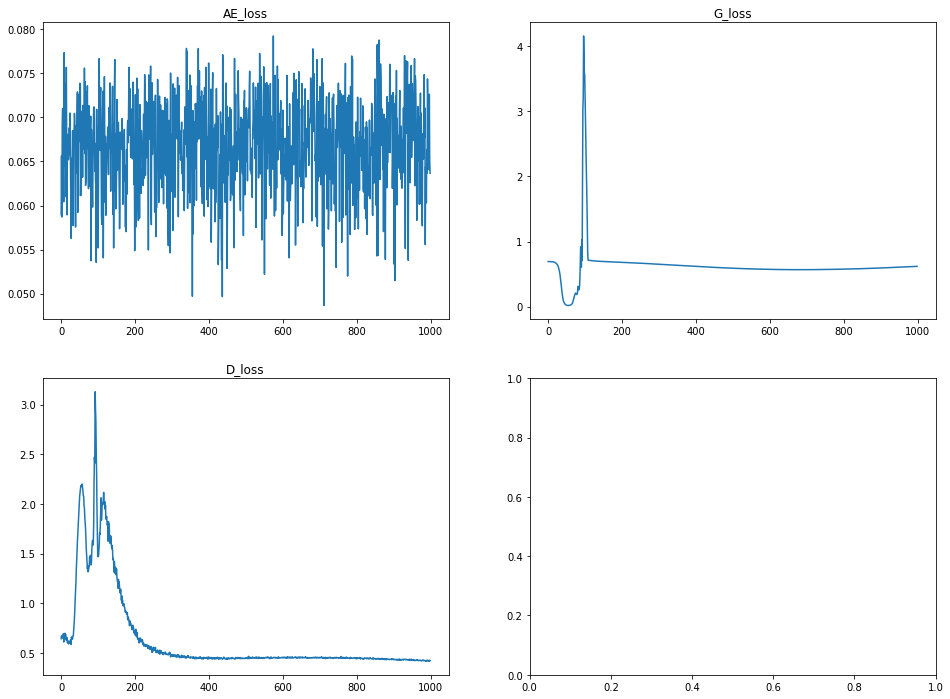

In [68]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(16,12))

ax[0, 0].plot(range(n_epochs-1), history["AE_loss"], label="AE_loss")
ax[0, 0].set_title("AE_loss")

ax[0, 1].plot(range(n_epochs-1), history["G_loss"], label="G_loss")
ax[0, 1].set_title("G_loss")

ax[1, 0].plot(range(n_epochs-1), history["D_loss"], label="D_loss")
ax[1, 0].set_title("D_loss")

plt.show()

In [69]:
image = train_set[0].reshape((1,48,96,96,1))
gen_image=np.squeeze(model.autoencoder.predict(image))
image = np.squeeze(image)

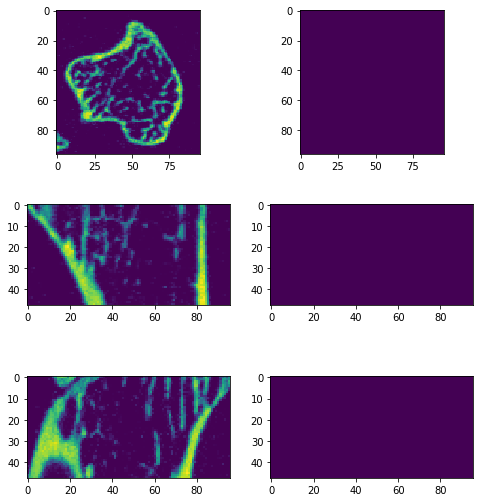

In [70]:
fig2, ax = plt.subplots(3,2, figsize=(8,9))
ax[0,0].imshow(image[35,:,:])
ax[0,1].imshow(gen_image[35,:,:])
ax[1,0].imshow(image[::-1,50,:])
ax[1,1].imshow(gen_image[::-1,50,:])
ax[2,0].imshow(image[::-1,:,60])
ax[2,1].imshow(gen_image[::-1,:,60])

In [45]:
model = AAE(encoded_dim=1000)
model.encoder.summary()

Model: "sequential_32"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_65 (Conv3D)           (None, 48, 96, 96, 16)    448       
_________________________________________________________________
dropout_24 (Dropout)         (None, 48, 96, 96, 16)    0         
_________________________________________________________________
conv3d_66 (Conv3D)           (None, 48, 96, 96, 16)    6928      
_________________________________________________________________
max_pooling3d_26 (MaxPooling (None, 24, 48, 48, 16)    0         
_________________________________________________________________
conv3d_67 (Conv3D)           (None, 24, 48, 48, 32)    13856     
_________________________________________________________________
dropout_25 (Dropout)         (None, 24, 48, 48, 32)    0         
_________________________________________________________________
conv3d_68 (Conv3D)           (None, 24, 48, 48, 32)  

In [48]:
model.decoder.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_63 (Dense)             (None, 6912)              6918912   
_________________________________________________________________
reshape_18 (Reshape)         (None, 3456, 1)           0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 3456, 64)          128       
_________________________________________________________________
reshape_19 (Reshape)         (None, 12, 24, 24, 64)    0         
_________________________________________________________________
conv3d_transpose_54 (Conv3DT (None, 12, 24, 24, 32)    55328     
_________________________________________________________________
conv3d_transpose_55 (Conv3DT (None, 24, 48, 48, 32)    27680     
_________________________________________________________________
conv3d_transpose_56 (Conv3DT (None, 24, 48, 48, 16)  